In [527]:
# !conda install tqdm -y

In [528]:
# !pip install seaborn

In [529]:
import os
import ast
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [530]:
# !pip install sktime

In [531]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sktime.transformations.panel.rocket import MiniRocketMultivariate

In [185]:
from tsai.all import *

In [7]:
my_setup()

os              : Linux-5.14.0-503.11.1.el9_5.x86_64-x86_64-with-glibc2.34
python          : 3.12.8
tsai            : 0.4.1
fastai          : 2.8.2
fastcore        : 1.8.2
torch           : 2.5.1+cu124
device          : 2 gpus (['NVIDIA L40S', 'NVIDIA L40S'])
cpu cores       : 64
threads per cpu : 1
RAM             : 1007.1 GB
GPU memory      : [44.99, 44.99, 44.99, 44.99] GB


In [8]:
def extend_df(
        df: pd.DataFrame, 
        target_size: int
    ) -> pd.DataFrame:

    current_size = len(df)
    last_row = df.iloc[[-1]]
    repeats = target_size - current_size
    extension = pd.concat([last_row] * repeats, ignore_index=True)
    extension.index = range(current_size, target_size)
    
    return pd.concat([df, extension])

In [9]:
df_meta = pd.read_csv('../../sensor_fusion/df_meta_withJSON_withTimes_goodDetections_min2700.csv', index_col=0)

In [10]:
df_meta.head()

,study_id,premature,gestational_age_weeks,post_menstrual_age_days,adjusted_age_weeks,chronological_age_weeks,over3m,sex,diagnosis,y_true,...,dirname_json,start_time1,stop_time1,start_time2,stop_time2,num_frames_mkv,num_frames_json,num_frames_diff,num_scaled_snippets,fnames_scaled_snippets
0,592,0,38,294.0,40,4,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/592-aafcb787-M-28-2010221627,2700,5400,-1,-1,7196,7197,1,2,"['592-aafcb787-M-28-2010221627_df_scaled_snippet_idx0.csv', '592-aafcb787-M-28-2010221627_df_scaled_snippet_idx1.csv']"
1,1838,0,40,330.0,47,7,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/1838-1976fc8e-M-44-2010271018,3450,6150,-1,-1,7202,7203,1,2,"['1838-1976fc8e-M-44-2010271018_df_scaled_snippet_idx0.csv', '1838-1976fc8e-M-44-2010271018_df_scaled_snippet_idx1.csv']"
2,8015,0,39,314.0,43,5,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/8015-d6a22f17-M-39-2010291126,1500,4200,-1,-1,7196,7197,1,2,"['8015-d6a22f17-M-39-2010291126_df_scaled_snippet_idx0.csv', '8015-d6a22f17-M-39-2010291126_df_scaled_snippet_idx1.csv']"
3,8026,0,40,488.0,69,29,1,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/8026-0e213ab6-M-207-2010301654,960,3660,-1,-1,7196,7197,1,2,"['8026-0e213ab6-M-207-2010301654_df_scaled_snippet_idx0.csv', '8026-0e213ab6-M-207-2010301654_df_scaled_snippet_idx1.csv']"
4,24034,0,37,339.0,45,11,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/24034-15d9bab8-M-76-2011051205_M,3690,6390,-1,-1,7196,7197,1,2,"['24034-15d9bab8-M-76-2011051205_M_df_scaled_snippet_idx0.csv', '24034-15d9bab8-M-76-2011051205_M_df_scaled_snippet_idx1.csv']"


In [11]:
# df_meta.shape

In [532]:
df_meta_Normal = df_meta[df_meta['diagnosis']=='Normal']
# df_meta_CP     = df_meta[df_meta['diagnosis']=='CP']
df_meta_CP     = df_meta[df_meta['diagnosis']!='Normal']

In [534]:
df_meta_Normal.shape, df_meta_CP.shape

((551, 28), (225, 28))

In [603]:
df_meta_CP_train, df_meta_CP_test = train_test_split(
    df_meta_CP, test_size=0.25, random_state=0
)

In [604]:
num_snippets_CP_train = int(df_meta_CP_train['num_scaled_snippets'].sum())

In [605]:
num_snippets_CP_test  = int(df_meta_CP_test['num_scaled_snippets'].sum())

In [606]:
num_snippets_CP_train, num_snippets_CP_test

(367, 129)

In [607]:
dfs_combined_CP_train = []

for i in tqdm( range( len(df_meta_CP_train) ) ):

    row = df_meta_CP_train.iloc[i]
    
    dirname_json = row['dirname_json']
    
    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for j, fname in enumerate(fnames_scaled_snippets_full[:]):

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            dfs_combined_CP_train.append( dfs_combined )
            
        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            dfs_combined_CP_train.append( dfs_combined_extended )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:28<00:00,  5.85it/s]


In [608]:
len(dfs_combined_CP_train)

367

In [609]:
# df_meta_CP[ df_meta_CP['over3m']==0 ]['num_scaled_snippets'].sum()

In [610]:
# df_meta_CP[ df_meta_CP['over3m']==1 ]['num_scaled_snippets'].sum()

In [611]:
dfs_combined_CP_test = []

for i in tqdm( range( len(df_meta_CP_test) ) ):

    row = df_meta_CP_test.iloc[i]
    
    dirname_json = row['dirname_json']

    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for j, fname in enumerate(fnames_scaled_snippets_full[:]):

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            dfs_combined_CP_test.append( dfs_combined )
            
        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            dfs_combined_CP_test.append( dfs_combined_extended )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:09<00:00,  5.73it/s]


In [612]:
len(dfs_combined_CP_test)

129

In [613]:
dfs_combined_Normal = []

for _, row in df_meta_Normal.sample( 
        num_snippets_CP_train + num_snippets_CP_test,
    ).iterrows():
# for i in tqdm( range( len(df_meta_Normal) ) ):

    # row = df_meta_Normal.iloc[i]
    
    dirname_json = row['dirname_json']
    
    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for fname in fnames_scaled_snippets_full[:1]:

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            dfs_combined_Normal.append( dfs_combined )

        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            dfs_combined_Normal.append( dfs_combined_extended )

In [614]:
dfs_combined_Normal_train = dfs_combined_Normal[:len(dfs_combined_CP_train)]

In [615]:
dfs_combined_Normal_test  = dfs_combined_Normal[len(dfs_combined_CP_train):]

In [616]:
# len(dfs_combined_Normal_train), len(dfs_combined_Normal_test)

In [617]:
dfs_combined_train = dfs_combined_CP_train + dfs_combined_Normal_train

In [618]:
dfs_combined_test  = dfs_combined_CP_test + dfs_combined_Normal_test

In [619]:
# len(dfs_combined_train), len(dfs_combined_test)

In [620]:
### BREAK HERE ####

In [621]:
X_train = []
for dfs_combined in dfs_combined_train:
    X_train.append( dfs_combined.values )

In [622]:
y_train = [1] * len(dfs_combined_CP_train) + [0] * len(dfs_combined_Normal_train)

In [623]:
y_train_arr = np.asarray(y_train)

In [624]:
X_test = []
for dfs_combined in dfs_combined_test:
    X_test.append( dfs_combined.values )

In [625]:
y_test = [1] * len(dfs_combined_CP_test) + [0] * len(dfs_combined_Normal_test)

In [626]:
y_test_arr = np.asarray(y_test)

In [627]:
# len(y_train_arr), len(y_test_arr)

In [628]:
X_train_arr = np.asarray(X_train).transpose( (0,2,1 ) )

In [629]:
X_test_arr  = np.asarray(X_test).transpose( (0,2,1 ) )

In [630]:
X_train_arr.shape, X_test_arr.shape

((734, 170, 2700), (258, 170, 2700))

In [631]:
lms_using4 = [
    'left_wrist','right_wrist','left_ankle','right_ankle'
]

In [632]:
lms_using8 = [
    'left_wrist','right_wrist','left_ankle','right_ankle',
    'left_shoulder','right_shoulder','left_hip','right_hip'
]

In [633]:
lms_using12 = [
    'left_wrist','right_wrist','left_ankle','right_ankle',
    'left_shoulder','right_shoulder','left_hip','right_hip',
    'left_elbow','right_elbow','left_knee','right_knee'
]

In [690]:
#### CHANGE THIS ####
lms_using = lms_using12

In [691]:
# Decide which columns/features to use

In [692]:
feature_sets = set( [col.split('__')[0] for col in dfs_combined.columns] )

In [693]:
feature_sets

{'lm2dists_centroid_2d',
 'lm2dists_centroid_3d',
 'lm2dists_framewise_2d',
 'lm2dists_framewise_3d',
 'lm_pair2dists_2d',
 'lm_pair2dists_3d',
 'lm_triple2angles',
 'polar_coords',
 'pos_2d',
 'pos_3d'}

In [694]:
feature_set2col_indices = {}
for feature_set in feature_sets:
    
    print(f'feature_set={feature_set}')
    
    col_indices = []
    for i, col in enumerate(dfs_combined.columns):
        if feature_set in col:
            if feature_set not in ['lm_triple2angles', 
                                   'lm_pair2dists_2d', 'lm_pair2dists_3d', 
                                   'polar_coords']:
                lm = '_'.join( col.split('__')[-1].split('_')[:-1] )
                if lm in lms_using: # only use centroid and framewise and pos of lms we're using
                    col_indices.append(i)
            else:
               col_indices.append(i)

    feature_set2col_indices[feature_set] = col_indices
    # print('***')

feature_set=lm_pair2dists_3d
feature_set=lm_triple2angles
feature_set=polar_coords
feature_set=lm2dists_centroid_2d
feature_set=lm2dists_centroid_3d
feature_set=pos_2d
feature_set=lm2dists_framewise_2d
feature_set=lm_pair2dists_2d
feature_set=lm2dists_framewise_3d
feature_set=pos_3d


In [695]:
feature_sets_2d = [
    'pos_2d',
    'lm2dists_framewise_2d',
    'lm2dists_centroid_2d',
    'lm_pair2dists_2d',
    'lm_triple2angles',
    'polar_coords'
]

In [696]:
feature_sets_3d = [
    'pos_3d',
    'lm2dists_framewise_3d',
    'lm2dists_centroid_3d',
    'lm_pair2dists_3d',
    'lm_triple2angles',
    'polar_coords'
]

In [697]:
# feature_set2col_indices.keys()

In [698]:
col_indices_total = []
for feature_set in feature_set2col_indices:
# for feature_set in feature_sets_2d:
# for feature_set in feature_sets_3d:
# for feature_set in ['pos_3d']:

    print(feature_set)

    ### EXCLUDE SOMETHING, LIKE POS_2D
    if feature_set != 'pos_2d':
        col_indices_tmp = feature_set2col_indices[feature_set]
        for col_idx in col_indices_tmp:
            col_indices_total.append(col_idx)
    
    # ### DON'T EXCLUDE ANYTHING
    # col_indices_tmp = feature_set2col_indices[feature_set]
    # for col_idx in col_indices_tmp:
    #     col_indices_total.append(col_idx)

lm_pair2dists_3d
lm_triple2angles
polar_coords
lm2dists_centroid_2d
lm2dists_centroid_3d
pos_2d
lm2dists_framewise_2d
lm_pair2dists_2d
lm2dists_framewise_3d
pos_3d


In [699]:
len( col_indices_total )

146

In [700]:
skip = 5

In [701]:
X_train_arr_smaller = X_train_arr[:,col_indices_total,::skip]
# X_train_arr_smaller = X_train_arr[:,:,::skip]
# X_train_arr_smaller = X_train_arr[:,col_indices,:]
# X_train_arr_smaller = X_train_arr[:,:,:]

In [702]:
X_test_arr_smaller = X_test_arr[:,col_indices_total,::skip]
# X_test_arr_smaller = X_test_arr[:,:,::skip]
# X_test_arr_smaller = X_test_arr[:,col_indices,:]
# X_test_arr_smaller = X_test_arr[:,:,:]

In [703]:
X_train_arr_smaller.shape, X_test_arr_smaller.shape

((734, 146, 540), (258, 146, 540))

In [704]:
X_train_and_test = np.concatenate([X_train_arr_smaller, X_test_arr_smaller], axis=0)

In [705]:
X_train_and_test.shape

(992, 146, 540)

In [706]:
y_train_and_test = np.concatenate([y_train_arr, y_test_arr])

In [707]:
y_train_and_test.shape

(992,)

In [708]:
# X_train_arr_smaller_cumsum = np.cumsum(X_train_arr_smaller, axis=-1)

In [709]:
# X_test_arr_smaller_cumsum = np.cumsum(X_test_arr_smaller, axis=-1)

In [710]:
# X_train_arr_smaller_cumsum.shape, X_test_arr_smaller_cumsum.shape

In [711]:
model = MiniRocketMultivariate()

In [712]:
model.fit(X_train_and_test, y_train_and_test)

MiniRocketMultivariate()

In [713]:
X_train_and_test_transformed = model.transform(X_train_and_test)

In [714]:
X_train_and_test_transformed.shape

(992, 9996)

In [715]:
X_train_and_test_transformed_arr = X_train_and_test_transformed.to_numpy()

In [716]:
### PCA and TSNE

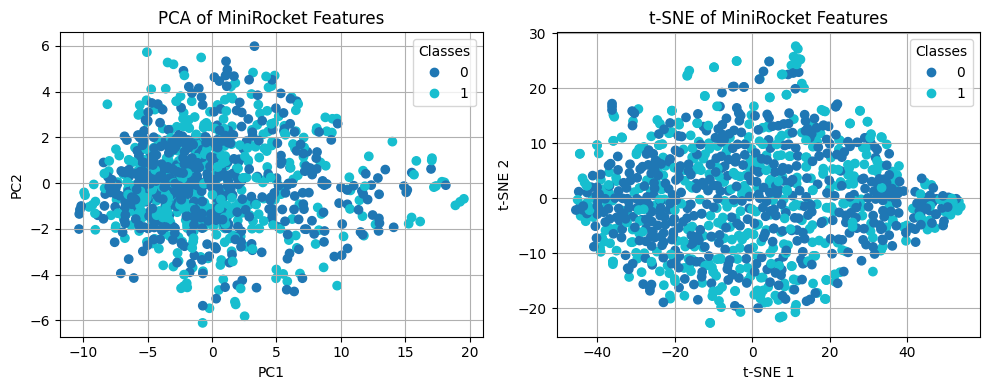

In [717]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_train_and_test)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_and_test_transformed_arr)

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_train_and_test_transformed_arr)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='tab10')
plt.title("PCA of MiniRocket Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.legend(*scatter.legend_elements(), title="Classes", loc='best')

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='tab10')
plt.title("t-SNE of MiniRocket Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid()
plt.legend(*scatter.legend_elements(), title="Classes", loc='best')

plt.tight_layout()
plt.savefig('Normal_v_Aberrant_pca_tsne_all_features_lms_using12.png')
plt.show()

In [523]:
# Isolation Forest with Normal samples v. CP samples (using MiniRocket features)

In [144]:
### Classification

In [151]:
# Step 4: Train a classifier (e.g., RidgeClassifierCV)
classifier = RidgeClassifierCV()
classifier.fit(X_train_transformed, y_train_arr)

RidgeClassifierCV()

In [152]:
accuracy = classifier.score(X_test_transformed, y_test_arr)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5217


In [100]:
X_tsai, y_tsai, splits = combine_split_data(
    [X_train_arr_smaller, X_test_arr_smaller], [y_train_arr, y_test_arr]
    # [X_train_arr_smaller_cumsum, X_test_arr_smaller_cumsum], [y_train_arr, y_test_arr]
)

In [101]:
len(X_tsai)

174

In [104]:
bs = 16
n_epochs = 100

In [105]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize()]

In [106]:
dsets = TSDatasets(X_tsai, y_tsai, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=batch_tfms)

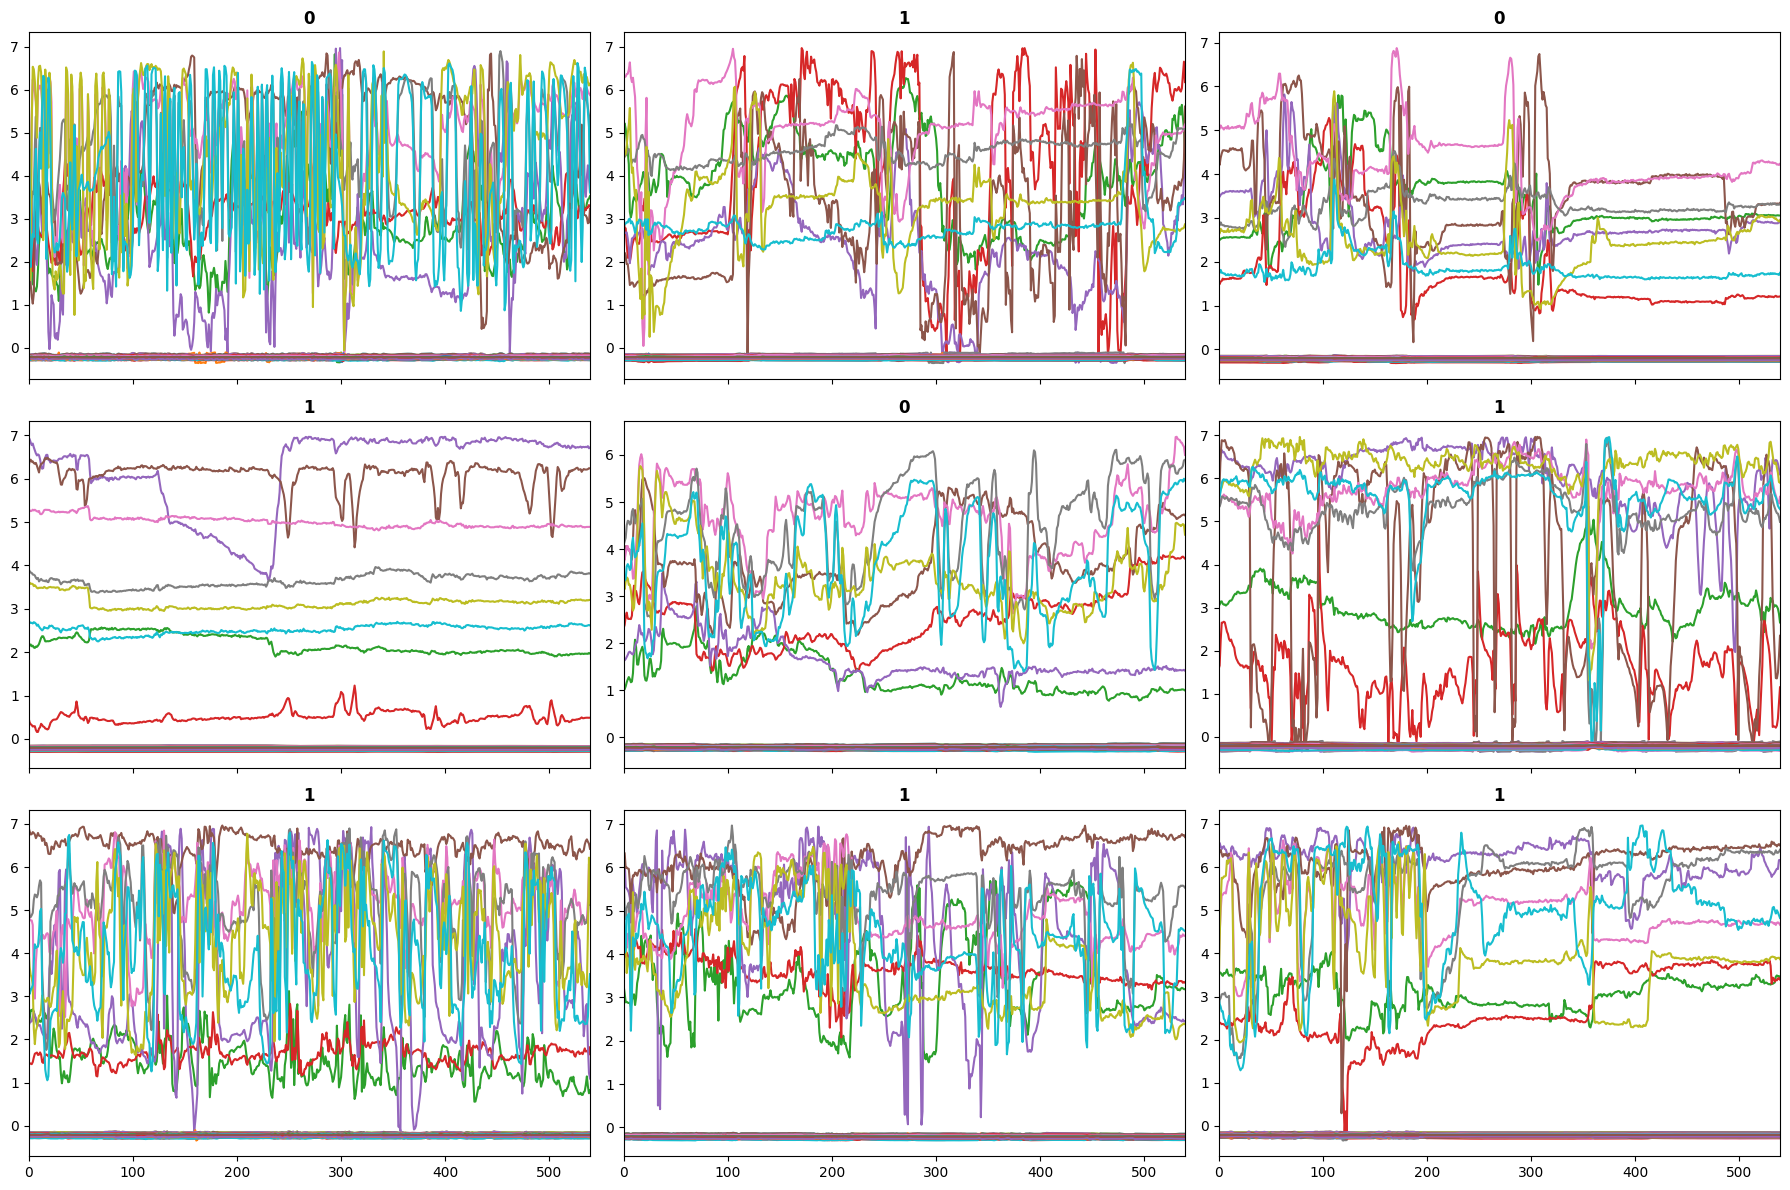

In [107]:
dls.show_batch()

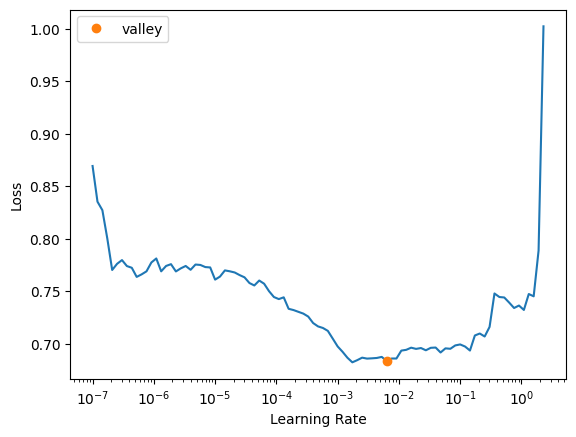

In [108]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, 
                metrics=[RocAucBinary(), accuracy, Precision(), F1Score()], 
                cbs=ShowGraphCallback2())
lr_max = learn.lr_find()[0]

In [109]:
lr_max

0.0063095735386013985

epoch,train_loss,valid_loss,roc_auc_score,accuracy,precision_score,f1_score,time
0,0.714267,0.703085,0.500945,0.500000,0.500000,0.666667,00:00
1,0.667526,0.712572,0.595463,0.500000,0.500000,0.666667,00:00
2,0.626246,0.751485,0.540643,0.521739,0.511111,0.676471,00:00
3,0.596126,0.755384,0.550095,0.630435,0.593750,0.690909,00:00
4,0.555905,0.914629,0.548204,0.543478,0.529412,0.631579,00:00
5,0.547589,0.869635,0.612476,0.586957,0.571429,0.627451,00:00
6,0.510051,1.208030,0.595463,0.608696,0.580645,0.666667,00:00
7,0.495665,1.730520,0.523629,0.456522,0.000000,0.000000,00:00
8,0.475087,5.933704,0.519849,0.500000,0.500000,0.080000,00:00
9,0.448667,4.054203,0.448015,0.500000,0.500000,0.148148,00:00


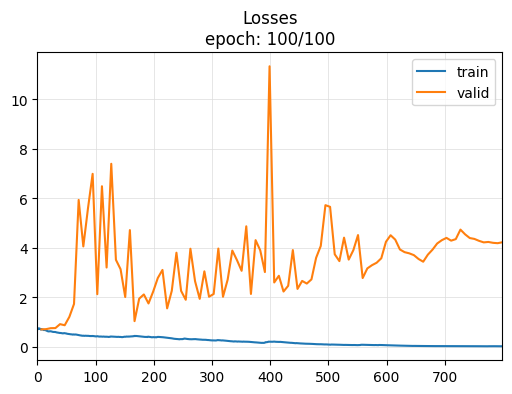

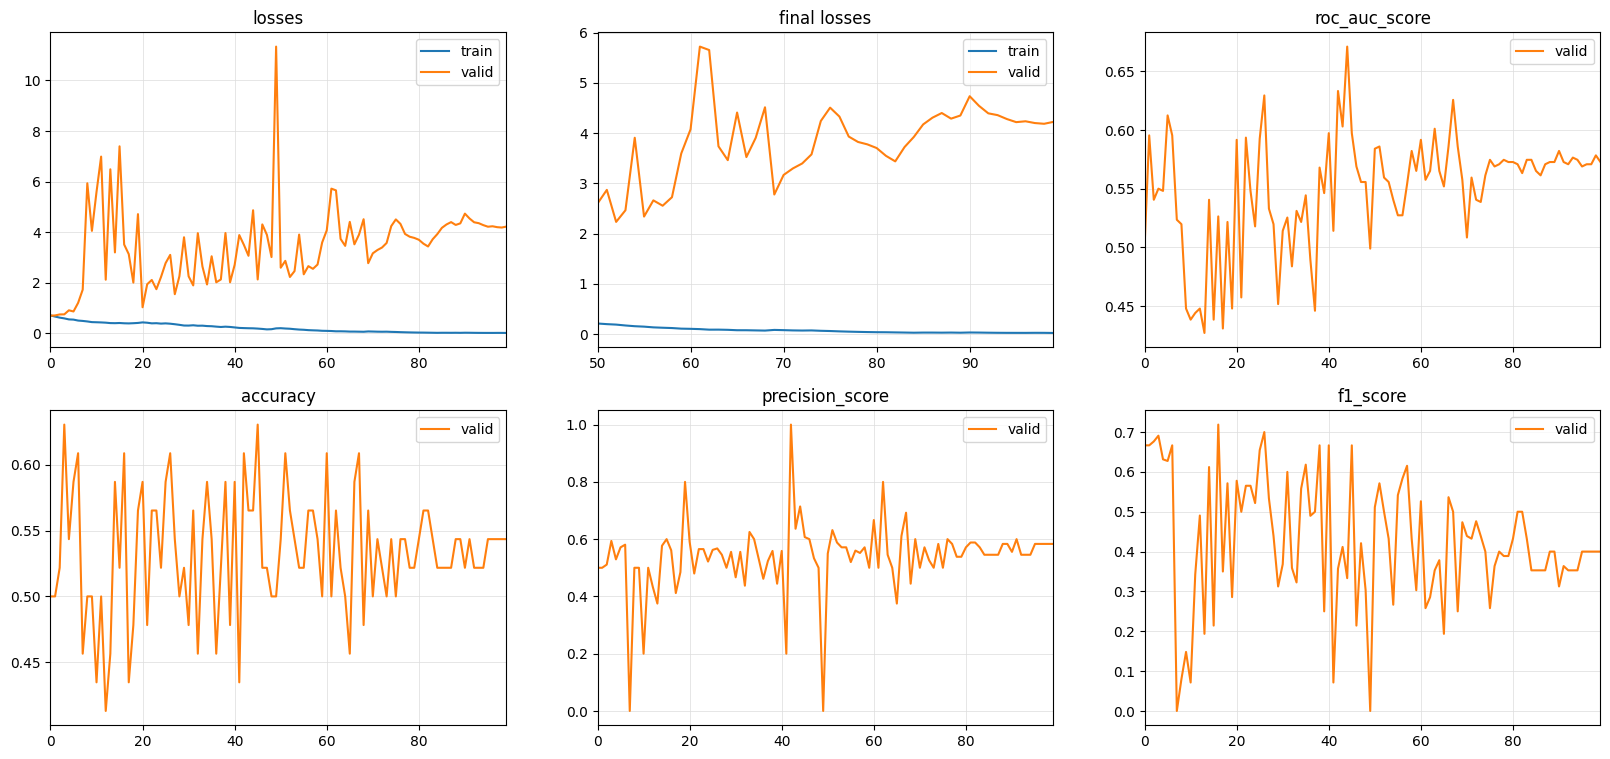


Elapsed time: 19.536157369613647


In [110]:
start = time.time()
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
print('\nElapsed time:', time.time() - start)